### Exercise 1

Let $\theta_1$ and $\theta_2$ be real valued parameters of the model

$$
y = \frac{\theta_1 x}{\theta_2 + x}.
$$

a. Choose two suitable prior distributions for $\theta_1$ and $\theta_2$  and use HMC algorithm to find their posterior distributions, conditioning on the observations

$$
x=(28,55,110,138,225,375)\\
y=(0.053,0.060,0.112,0.105,0.099,0.122).
$$

b. Discuss how different parameters for both priors and the HMC algorithm lead to different estimates. 

c. Plot the most reliable posterior distributions, according to convergence checks on the traces.

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
pyro.set_rng_seed(0)

In [2]:
def model(x_data, dist : torch.distributions.Distribution):
    pyro.clear_param_store()
    theta_1 = pyro.sample( 'theta_1', dist )
    theta_2 = pyro.sample( 'theta_2', dist )
    y = pyro.deterministic( 'y', x_data*theta_1/(theta_2+x_data) )
    return y

y_data = torch.tensor( [0.053,0.060,0.112,0.105,0.099,0.122] )
x = torch.tensor( [28,55,110,138,225,375] )
conditioned_model = pyro.condition( model, data={'y': y_data} )
conditioned_model(x, dist.Exponential(1))

tensor([0.0530, 0.0600, 0.1120, 0.1050, 0.0990, 0.1220])

In [3]:
def run_mcmc(kernel, n_samples, warmup, n_chains, data, dist: torch.distributions.Distribution):
    mcmc = MCMC(kernel, num_samples=n_samples, warmup_steps=warmup, num_chains=n_chains) 
    mcmc.run(x_data=data, dist=dist)
    return mcmc

def plot_posterior_distr(mcmc):
    mcmc_samples = mcmc.get_samples(group_by_chain=True)
    
    for key in mcmc_samples.keys():
        print("expected ", key , " = ", mcmc_samples[key].mean().item())
        
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    for i, key in enumerate(mcmc_samples.keys()):
        sns.distplot(mcmc_samples[key], ax=ax[i])
        ax[i].set_title("P(" + key + " | y=obs )")
        ax[i].set_xlabel(xlabel=key)

def plot_chains(mcmc):
    mcmc_samples = mcmc.get_samples(group_by_chain=True)
    n_chains = mcmc.num_chains
    n_samples = mcmc.num_samples
    print("n_chains", n_chains, " n_samples", n_samples)
    
    fig, ax = plt.subplots(len( mcmc_samples ), n_chains, figsize=(12,5))
    plt.subplots_adjust(bottom=-0.5)
    for i, key in enumerate(mcmc_samples.keys()):
        for j, chain in enumerate(mcmc_samples[key]):
            sns.lineplot( x=range(n_samples), y=chain, ax=ax[i][j] )
            ax[i][j].set_title( key+" chain " + str( j + 1 ) )

In [4]:

mcmc = run_mcmc( HMC(model=conditioned_model), 500, 1000, 3, x, dist.Exponential(1) )
print(mcmc.get_samples().keys())




dict_keys(['theta_1', 'theta_2'])


n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      1.05      1.04      0.73      0.00      2.41    170.58      1.01
   theta_2      1.04      0.98      0.74      0.00      2.33    198.26      1.00

Number of divergences: 0


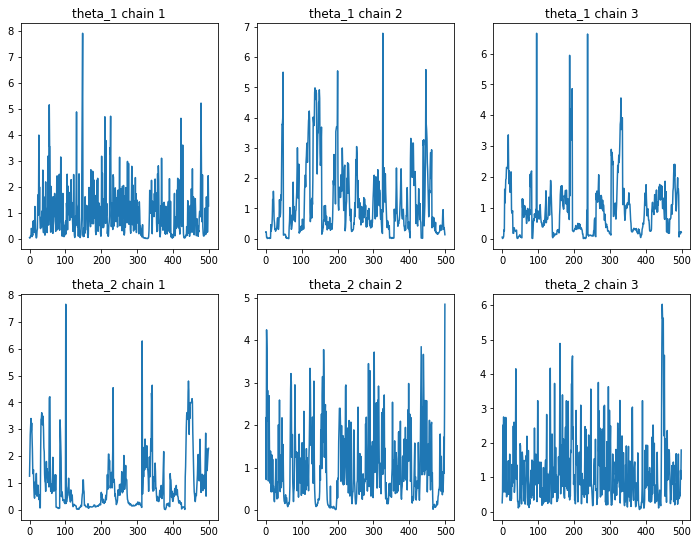

In [5]:
plot_chains(mcmc)
mcmc.summary()

expected  theta_1  =  1.0472233295440674
expected  theta_2  =  1.0411536693572998


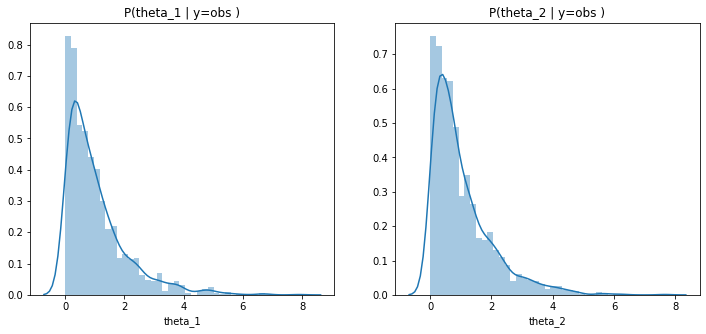

In [6]:
plot_posterior_distr(mcmc)

In [7]:
mcmc = run_mcmc( HMC(model=conditioned_model), 500, 1000, 3, x, dist.Normal(0,1))

n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1     -0.14      1.01     -0.15     -1.62      1.68    291.03      1.01
   theta_2      0.07      1.05      0.05     -1.72      1.76     35.15      1.04

Number of divergences: 0


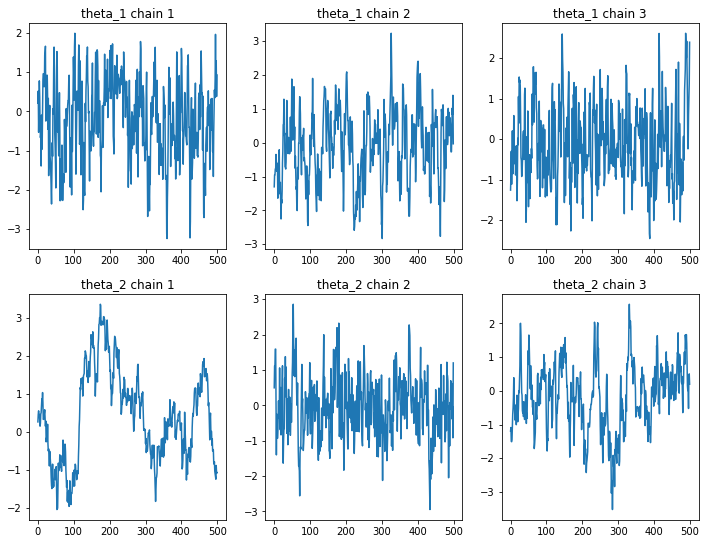

In [8]:
plot_chains(mcmc)
mcmc.summary()

expected  theta_1  =  -0.13867595791816711
expected  theta_2  =  0.0671653300523758


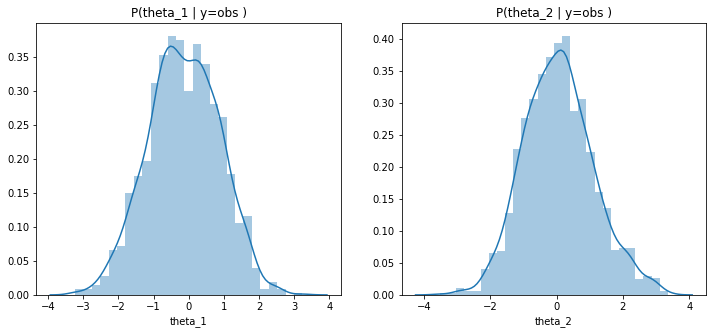

In [9]:
plot_posterior_distr(mcmc)

In [10]:
mcmc = run_mcmc( HMC(model=conditioned_model), 500, 1000, 3, x, dist.Exponential(15) )

n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.07      0.06      0.05      0.00      0.16    828.31      1.00
   theta_2      0.07      0.07      0.05      0.00      0.16    286.22      1.00

Number of divergences: 0


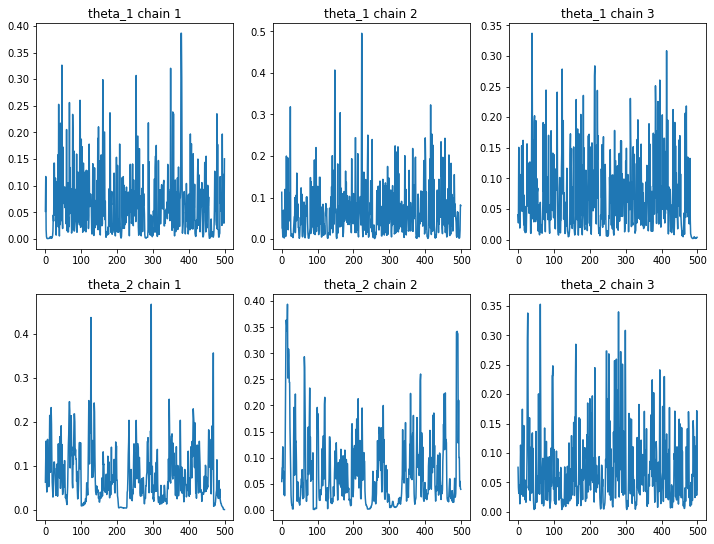

In [11]:
plot_chains(mcmc)
mcmc.summary()

expected  theta_1  =  0.06750692427158356
expected  theta_2  =  0.073778435587883


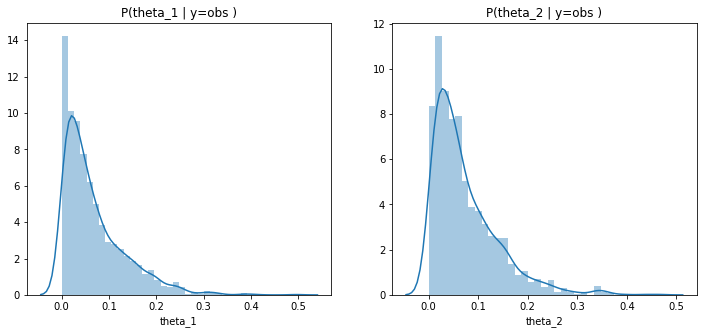

In [12]:
plot_posterior_distr(mcmc)

In [13]:
mcmc = run_mcmc( HMC(model=conditioned_model), 500, 1000, 3, x, dist.Normal(0,100))

n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1     -5.73     98.69     -0.68   -185.20    143.33     41.62      1.02
   theta_2     10.41    104.68     12.53   -158.99    177.87    125.41      1.02

Number of divergences: 0


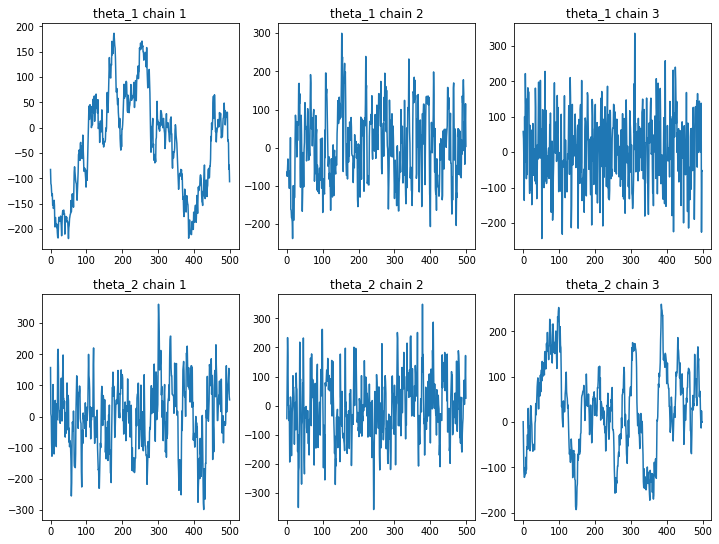

In [14]:
plot_chains(mcmc)
mcmc.summary()

expected  theta_1  =  -5.7267351150512695
expected  theta_2  =  10.41047477722168


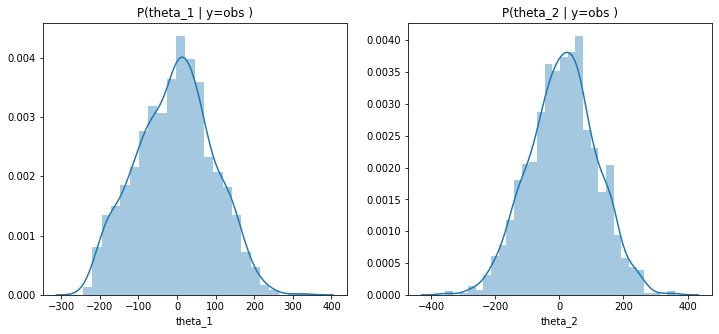

In [15]:
plot_posterior_distr(mcmc)

In [16]:
mcmc = run_mcmc( HMC(model=conditioned_model), 500, 1000, 3, x, dist.Exponential(0.5) )

n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      2.09      2.18      1.38      0.00      4.75    272.87      1.02
   theta_2      1.87      1.89      1.27      0.01      4.28    522.34      1.00

Number of divergences: 0


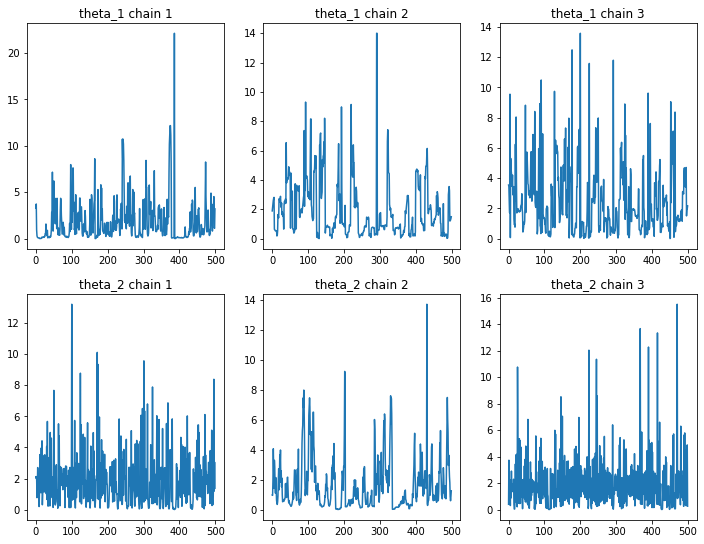

In [17]:
plot_chains(mcmc)
mcmc.summary()

expected  theta_1  =  2.0859215259552
expected  theta_2  =  1.8650258779525757


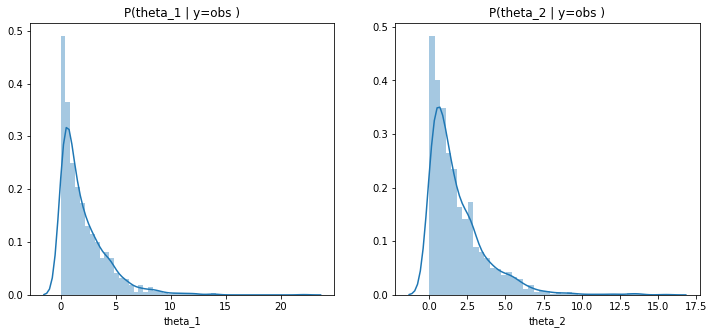

In [20]:
plot_posterior_distr(mcmc)

From the above tests it is possible to observe that the *exponential* distribution is more suitable for $\theta_1$ and $\theta_2$ than the *normal*, as the first result in a higher number of effective samples and a more stable $\hat{R}$. Moreover, when $\theta_1, \: \theta_2 \sim Exp(15)$ MCMC is likely to produce an higher number of effective samples compared to $Exp(1)$ and $Exp(0.5)$.

### Exercise 2

A bivariate Gibbs sampler for a vector $x=(x_1,x_2)$ draws iteratively from the posterior conditional distributions in the following way:
- choose a starting value $p(x_1|y,x_2^{(0)})$
- for each iteration $i$:
    - draw $x_2(i)$ from $p(x_2|y,x_1^{(i-1)})$
    - draw $x_1(i)$ from $p(x_1|y,x_2^{(i)})$

a. Supposing that samples are drawn from a bivariate normal distribution

$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
    implement a Gibbs sampler for $x$ which takes as inputs the number of iterations `iters` and the number of warmup draws `warmup`.

b. Use your implementation of Gibbs sampler to infer the parameters $\theta=(\theta_1,\theta_2)$ from **Exercise 1**.

In [ ]:
def gibbs_sampler(iters, warmup):
    